<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-09-18' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "9309888" #@param {type:"string"}
Student_full_name = "John Hayes" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# Introduction

#### Note
This notebook has been tested on a locally run juypter notebook as I could not get a single sucessful full execution on Google Colab without constant issues with it disconnecting from a hosted notebook. The sections which took the most time did not execute any more quickly when I used a locally hosted notebook.

### MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

### Etivity1 Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


### Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import scipy.optimize as optimize
from scipy.special import softmax

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az

import pymc3 as pm
import random
from IPython.display import HTML

import theano as tt

from skimage.color import rgb2gray

from collections import Counter
import datetime



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Setting the same seed allows the same digits to be used on each execution for comparison. Commented out to see how well it performs on other digits in the range.

In [6]:
print("Etivity-1 start time {}".format(datetime.datetime.now().time()))

# Setting a seed:
#np.random.seed(123)

Etivity-1 start time 10:55:26.416591


#### Any functions needed/used later on.

In [7]:
def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

def grayscale(img):
    #COLOR_BGR2GRAY COLOR_RGB2GRAY
    return rgb2gray(img)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        #gray = np.resize(grayscale(images[i]), (32, 32, 1))
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result

#---------------------------------------------------------------------------
def plot_digits(instances, images_per_row=5, **options):
    """
    Plot digits as 28x28 size
    """
    
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")
    
    
#---------------------------------------------------------------------------        
def plot_distribution(data, class_num):
    """
    Plot the class distribution
    """
    fig, ax = plt.subplots(figsize=(9,9))
    ind = np.arange(class_num)

    # Add outline to make it easier to see - from Carlos Santiago
    n, bins, patches = ax.hist(data, ec='black', align='mid')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    ax.set_title(r'Histogram of Digit images')
    plt.show()

#---------------------------------------------------------------------------        
def calc_bay_pred(x_values, classes, train_shape, posterior_sample):
    """
    Bayesian prediction - return the class that has the highest posterior probability
    """

    y_pred_Bayesian=[]

    for i in range(x_values.shape[0]):
        val=np.zeros((1,len(classes)))
    
        for s in range(posterior_sample['beta'].shape[0]):
            beta = np.hstack([np.zeros((train_shape, 1)),  posterior['beta'][s,:] ])
            alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
            val = val + softmax((np.array([x_values[i,:].dot(beta) + alpha])))
    
        mean_probability = val/posterior['beta'].shape[0]
        y_pred_Bayesian.append( np.argmax(mean_probability))
        
    return y_pred_Bayesian
    
    
#---------------------------------------------------------------------------    
def show_images(images_array, x_values, num_to_show=10, img_size=28, gray=False):
    """
    Display a number of images in colour or grayscale. It will alter the number
    displayed based on trying to align all the images into even number per row
    """
    
    # Calc the number per row depending on the number to display.
    # Set 8 as the max number
    div = 8
    tmp = [num_to_show // div + (1 if x < num_to_show % div else 0) for x in range (div)]
    col = len(tmp)
    row = tmp[1]
    
    num_to_show = (col * row)
    
    fig, axs = plt.subplots(row, col, figsize=(10, 6))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    # Show images with and without grayscale applied
    for i in range(num_to_show):
        index = images_array[i]
        image = x_values[index,:].reshape(img_size, img_size)
        axs[i].axis('off')
        if (gray == False):
            axs[i].imshow(image)
        else:
            axs[i].imshow(image,cmap="Greys_r")

### General variables <a id='gen_vars'></a>
Set some variables that will be used throughout. These are generally the only ones you need to change to test different cases, I.E sample size, how many digits to test and number of each to test with.

In [8]:
# Set the max limit, over which the data being printed will be reduced to a summary.
# Default is 1000 and that seems too much 
np.set_printoptions(threshold=100)
max_num_of_classes = 10

# Set the number instances that will be selected for each class (digit) that is chosen
# Increasing this, increases execution time.
num_class_instances = 5000

# We select the number of Classes we want. 3 specified in the etivity requirements.
num_classes_to_use = 3

# The number of samples to use from the adjusted prior list (a.k.a posterior - being the probability
# after the application of new information)
# Increasing this will greatly increase the run time
num_of_posterior_samples = 400

### Dataset <a id='dataset'></a>

The MINST (Modified National Institute of Standards and Technology) (http://yann.lecun.com/exdb/mnist/) dataset is a collection of handwritten digits with 60,000 examples and 10,000 training sets.

#### Loading the MNIST dataset

Load from either google colab or from local disk. For now local disk is easier for me as having issues uploading the 109MB file to colab and also constant disconnection from the notebook instance.

In [9]:

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Enrique/Data/'

    # MNIST Data
    train_data = Path + 'mnist_train.csv'
    test_data = Path + 'mnist_test.csv'
else:
    Path = "./"

Load the csv files into Pandas `DataFrame` type.

In [10]:

# MNIST CSV Data from sharepoint
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# Training data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

image_dimension = int(np.sqrt(X_test.shape[1]))
print("Using {} as image dimension".format(image_dimension))


(60000, 784)
(10000, 784)
Using 28 as image dimension


#### Normalise the data <a id='normalised'></a>
Normalisation is the process of reducing the dataset to a comon scale to prevent problems arising when you try to combine them as features. In this case we are keeping the values between 0 and 1. In the original dataset, 255 represents black and 0 represents white.

In [11]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print("Min value {} maximum value {}".format(minv,maxv))

Min value 0.0 maximum value 1.0


### Description of Data <a id='data_description'></a>

#### I want to visualise the types of images we are dealing with.

The code below is from https://github.com/iamkrut/MNIST_handwriting_classification/blob/master/main.py and reads the raw data from the MINST site. It will create a `./data/MNIST/raw` directory with the following files:

* `t10k-images-idx3-ubyte`
* `t10k-labels-idx1-ubyte`
* `train-images-idx3-ubyte`
* `train-labels-idx1-ubyte`
* `t10k-images-idx3-ubyte.gz`
* `t10k-labels-idx1-ubyte.gz`
* `train-images-idx3-ubyte.gz`
* `train-labels-idx1-ubyte.gz`


<class 'torchvision.datasets.mnist.MNIST'>


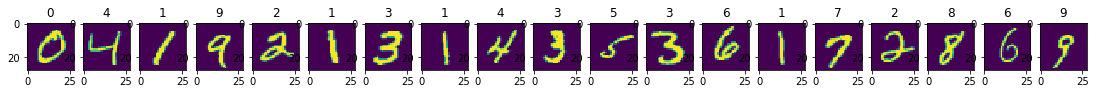

In [12]:
# For displaying the images
import torch
from torchvision import transforms
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

print(type(mnist_trainset))

# Show some of the images/data
number_to_print = 20
fig=plt.figure(figsize=(20, 12))

for i in range(1, number_to_print):
    
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, number_to_print, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
    
plt.show()

This section prints some basic information about the dataset from the CSV files - number of examples, shape etc.

In [13]:
# Number of examples
n_train = len(X_train)
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]
print(X_train.shape)

# unique classes/labels in the training dataset.
alltotal = set(y_train)
total_num_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Total number of classes =", total_num_classes)
print("Test data shape {}".format(X_test.shape[1]))

(60000, 784)
Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Total number of classes = 10
Test data shape 784


### Class Distribution <a id='class_distro'></a>

Each 'class' represents a different digit and there are 10 different types in the dataset (0 - 9)

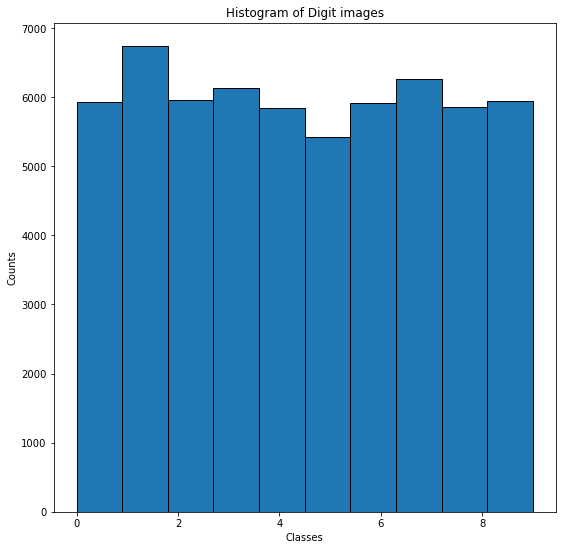

In [14]:
plot_distribution(y_train, total_num_classes)

### Downsampling
We are only selecting a subset from the range of digits available for analysis.

#### Randomly selecting 3 of the 10 Digit Classes

In [15]:

# Empty list to append the random digit classes we select:
classes = []

# We select 'num_classes_to_use' digits at random and make sure they are unique:
while len(classes) < num_classes_to_use:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0, total_num_classes)    

    # Append the digit if it's not already in our list of classes:    
    if num2choose not in classes:        
        classes.append(num2choose)
        
print("Unorted classes chosen {}".format(classes))

# Sorting the Classes smallest to largest    
classes.sort()

# print classes selected
print("Classes chosen sorted {}".format(classes))

Unorted classes chosen [6, 5, 0]
Classes chosen sorted [0, 5, 6]


The numpy `where(condition[, x, y])` method will return values from x or y depending on condition, so for below, we are selecting images that are in the training set.

In [16]:

inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:

    imgs = X_train[np.where(y_train==r)[0], :]
    print("Using class {}, curr image shape {}".format(r, imgs.shape))
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:num_class_instances,:])
    labels.append(np.ones(num_class_instances)*r)
    
# Shaping inputs and labels in the right format. vstack, alters the contents to be vertical
# So from ([1, 2, 3])
#    to array([[1],
#              [2],
#              [3]])
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)
print("Xtrain type is now {}".format(type(X_train)))


Using class 0, curr image shape (5923, 784)
Using class 5, curr image shape (5421, 784)
Using class 6, curr image shape (5918, 784)
Xtrain type is now <class 'numpy.ndarray'>


I want to get some indication of what I am dealing with and also confirm that the number of samples selected match the value of `num_class_instances` times the number of classes selected.

In [17]:
print(inputs)

print(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [0. 0. 0. ... 6. 6. 6.]
(15000, 784)
(15000,)


#### Show the distribution with the new selected classes

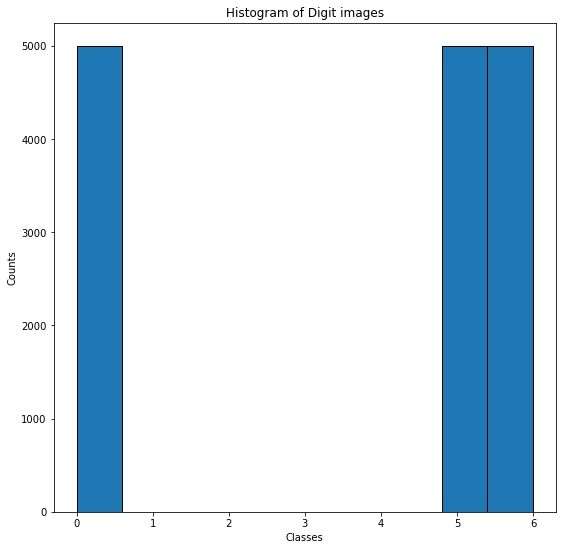

In [18]:
plot_distribution(y_train, num_classes_to_use)

The plot function is using 28x28 which is means 784 is required as the size of the array and this is confirmed by the shape output above.<br><br>
Below we are plotting a random sample of 100 from the list of chosen classes to get an idea of what type of handwritten digits we are dealing with.

Text(0.5, 1.0, 'Original')

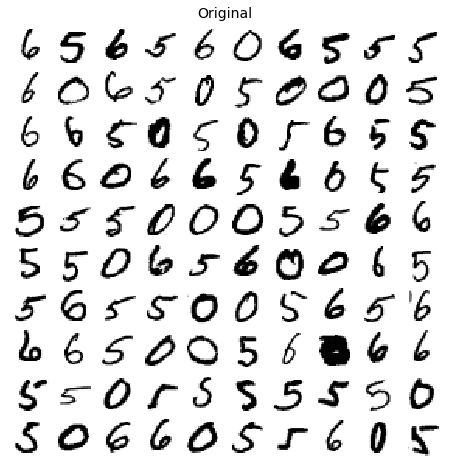

In [19]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices at random from each of the 3 classes to show:
label_indices = random.sample(range(0, len(X_train)), 100)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=10)
plt.title("Original", fontsize=14)

Printing the labels will give an indication as to what range of samples the above are from. From what I can see the list displayed generally seems to have a good range from the available set.

In [20]:
print (label_indices)

[10138, 5097, 14446, 5712, 12955, 3290, 12618, 8960, 7856, 7728, 14424, 2768, 12659, 9951, 281, 9773, 2710, 2904, 4141, 7170, 14688, 14813, 9252, 3049, 6571, 235, 6591, 13255, 6683, 7108, 11880, 13500, 4193, 14064, 10940, 6903, 11683, 13887, 5169, 8662, 8852, 7141, 6825, 164, 799, 444, 6274, 9942, 11733, 11229, 9459, 6472, 3241, 13491, 8291, 10627, 2435, 1902, 12084, 9980, 5663, 14174, 7908, 6419, 632, 3647, 5252, 12170, 6972, 13144, 13551, 10004, 6741, 1674, 3447, 9214, 10482, 3252, 11901, 10666, 5423, 9788, 2562, 9808, 6053, 7664, 8213, 6121, 7667, 1783, 5337, 2303, 12998, 13896, 915, 7754, 6630, 12321, 4012, 6944]


###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [21]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train_shuf, y_train_shuf = shuffle(X_train, y_train)

#### Print shape of your validation and training set

In [22]:
print("X training data shape {}".format(X_train.shape))
print("X validation set hape {}".format(X_val.shape))
print("Y training data shape {}".format(y_train.shape))
print("Y validation data shape {}".format(y_val.shape))

X training data shape (12000, 784)
X validation set hape (3000, 784)
Y training data shape (12000,)
Y validation data shape (3000,)


### Encoding the Class labels for the Probabilistic ML Model

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General Multinomial Logistic regression <a id='gen_multinomial_lr'></a>
* Using an integer for `random_state` will produce the same results each time
* `max_iter` - max number of iterations
* `solver` is the optimisation algorithm to use
* `multi_class` if you are using more than 2 classes

In [23]:
# General-recipe ML Multinomial logistic regression
gen_model_log = LogisticRegression(random_state=0,
                         max_iter=2000,
                         C=100,
                         solver='lbfgs',
                         multi_class='multinomial').fit(X_train_shuf, y_train_shuf)

# Classification:
y_pred_logi = gen_model_log.predict(X_val)
y_pred_logi_prob = gen_model_log.predict_proba(X_val)

prob_classmax = np.max(y_pred_logi_prob, axis=1)

# Computing the Accuracy:
print("Accuracy =", accuracy_score(y_pred_logi, y_val))

Accuracy = 0.9636666666666667


Change 1 input to see is the accuracy improves - a 25 fold increase in iterations.

In [24]:
# General-recipe ML Multinomial logistic regression
gen_model_log_10 = LogisticRegression(random_state=0,
                         max_iter=50000,
                         C=100,
                         solver='lbfgs',
                         multi_class='multinomial').fit(X_train_shuf, y_train_shuf)

# Classification:
y_pred_logi_10 = gen_model_log_10.predict(X_val)
y_pred_logi_prob_10 = gen_model_log_10.predict_proba(X_val)

prob_classmax_10 = np.max(y_pred_logi_prob_10, axis=1)

# Computing the Accuracy:
print("Accuracy =", accuracy_score(y_pred_logi_10, y_val))

Accuracy = 0.9636666666666667


<a id='gen_mlr_times'></a>
Both results were the same across different values of classes and number of instances of each of those classes, so no increase in accuracy would suggest other paramaters/inputs will need to change if I want to see greater accuracy. The first 4 points below were using the digits 1,2 & 6<br>
* When I set the number of instances to use from each class to 1000 and the number of postier samples was 300, the accuracy was 0.9633333333333334. It took 8 min 4 sec to execute.
* When I set the number of instances to use from each class to 2000 and the number of postier samples was 300, the accuracy was 0.975. It took 12 min and 38 seconds to run.
* When I set the number of instances to use from each class to 2000 and the number of postier samples was 1000, the accuracy was 0.975. It took 1hr 16 min to run.
* When I set the number of instances to use from each class to 5000 and the number of postier samples was 500 the accuracy was 0.974. It took 59 min and 12 seconds to run.
* When I did not use a seed and the digits chosen changed to 0,1 & 6, the accuracy increased to 99% for 5000 & 500 values but decreased for other sets E.G 1,7,9

In [25]:
np.sort(prob_classmax)

array([0.50678747, 0.52361872, 0.54426117, ..., 1.        , 1.        ,
       1.        ])

#### Print out some information on the incorrect results selected<br>
The shape is the number of wrong instances.

In [26]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]
prob_classmax[y_pred_logi!=y_val].shape

(109,)

In [27]:
np.array(y_pred_logi)
np.array(y_pred_logi).shape

(3000,)

#### Display a confusion matrix <a id='confusion_matrix'></a>
This summarises the performance of the algorithm by displaying the results in table format. It presents the errors being made along with types of errors, I.E false positives/negatives and true postives/negatives or if it is confusing one label for another.<br>
* The diagonal (in yellow) represents the correcly labeled values for those labels.
* The others are what label was incorrectly classified as what value.


Text(0.5, 69.0, 'Predicted Label')

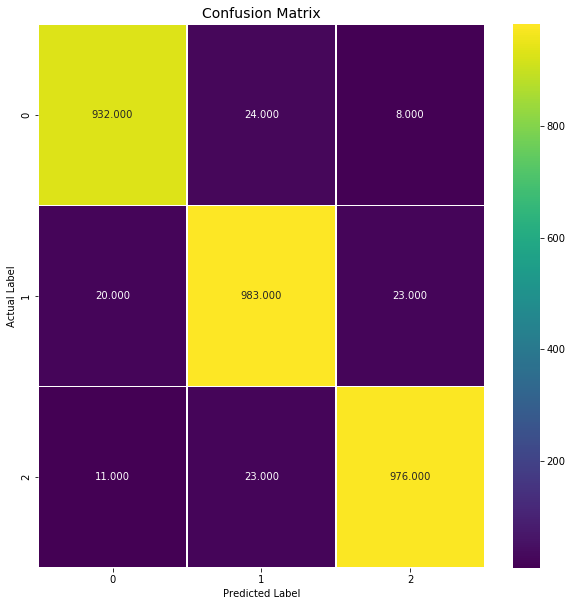

In [28]:
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix', fontsize=14)
cm = metrics.confusion_matrix(y_val, y_pred_logi)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.6, cmap = 'viridis')

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

#### Print some information on model performance <a id='model_stats'></a>

In [29]:
y_true = y_val
y_pred = y_pred_logi

target_names_lst = []

for digit in classes:
  target_names_lst.append("Digit/class {}".format(digit))

print(classification_report(y_true, y_pred, target_names=target_names_lst, digits=4))

               precision    recall  f1-score   support

Digit/class 0     0.9678    0.9668    0.9673       964
Digit/class 5     0.9544    0.9581    0.9562      1026
Digit/class 6     0.9692    0.9663    0.9678      1010

     accuracy                         0.9637      3000
    macro avg     0.9638    0.9637    0.9638      3000
 weighted avg     0.9637    0.9637    0.9637      3000



#### Precision
It is a measure of quality. It shows the correctly predicted true positives to the actual number, so how many of the true positives were actually found.
#### Recall
It is how many true positives were found.

#### F1-Score
It is the measue of the accuracy and is calculated from precision and recall values.You can use it as a comparison between the precision and recall values. <br>

In the above example, all 3 measurements are similarily high and close together, indicating that at least on this run with those values and that sample set, the model doesn't have too many issues. On certain sets of digits (1,2,6 for example), all the values were 98%+.


### Probabilistic Multinomial Logistic Regression <a id='probabilistic_ml_regression'></a>

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:

Using PyMC3 to build a model.

In [30]:
# We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1

y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train_shuf.reshape(-1,1))
x_train_shape = X_train_shuf.shape[1]
print("Shuffle X_train shape {}".format(x_train_shape))

# number of classes
num_classes = len(classes)
print("Number of classes {}".format(num_classes))

# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(x_train_shape, num_classes - 1).astype(floatX)
init_a = np.random.randn(num_classes - 1).astype(floatX)

# Items within the 'with' statement will be associated with the model
with pm.Model() as prob_multi_logistic:
    
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(x_train_shape, num_classes-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(num_classes - 1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((x_train_shape, 1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train_shuf, β1) + α1
    
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)


Shuffle X_train shape 784
Number of classes 3


In [31]:
print(y_2_bin)

[[0 1 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 0 1]
 [1 0 0]]


#### Test with different number of itterations
https://docs.pymc.io/notebooks/variational_api_quickstart.html
    
* `advi` is automatic differentiation variational inference. This automatically derives an efficient variational inference algorithm (https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
* Testing with smaller number of iterations when `num_class_instances` was increased to a 4 digit number reduces the run time
* Testing above 10k iterations was taking too long, so they were not kept.

Finished [100%]: Average Loss = 10,255


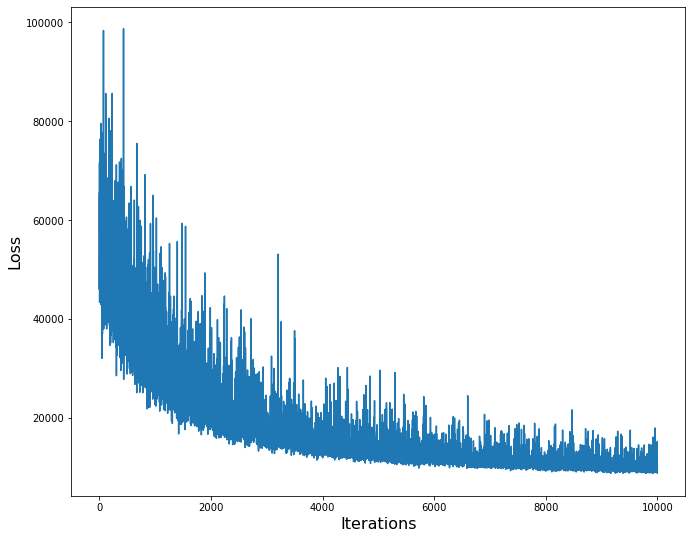

In [32]:
with prob_multi_logistic:
    approx10k = pm.fit(10000, method='advi')
    
plt.figure(figsize=(11,9))
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(approx10k.hist)


Finished [100%]: Average Loss = 16,384


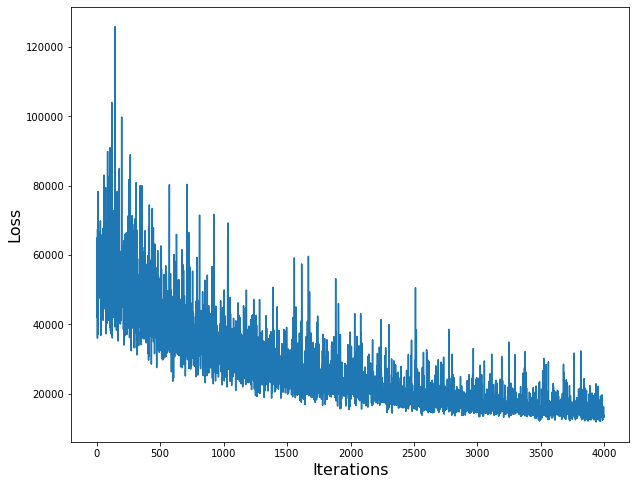

In [33]:
with prob_multi_logistic:
    approx4k = pm.fit(4000, method='advi')
    
plt.figure(figsize=(10,8))
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(approx4k.hist)

The above 2 graphs show the loss after each iteration and you can see that it decreases sharply but there is very little change after between 3500 - 4000 iterations, suggesting the run time could be reduced by lowering the iterations without much of an increase in loss. I have tested this in the 2nd graph.

#### Get samples from the posterior set using the given step methods.
* From https://docs.pymc.io/api/inference.html

In [34]:
posterior = approx10k.sample(draws=num_of_posterior_samples)

#### Test some images <a id='softmax_image'></a>
Applying softmax (computing the exponential) will ensure that each value will have a probability that increases the value of the higher scores and decreases the value of hte lower scores, thereby given a better value from which to interpret as probabilities.

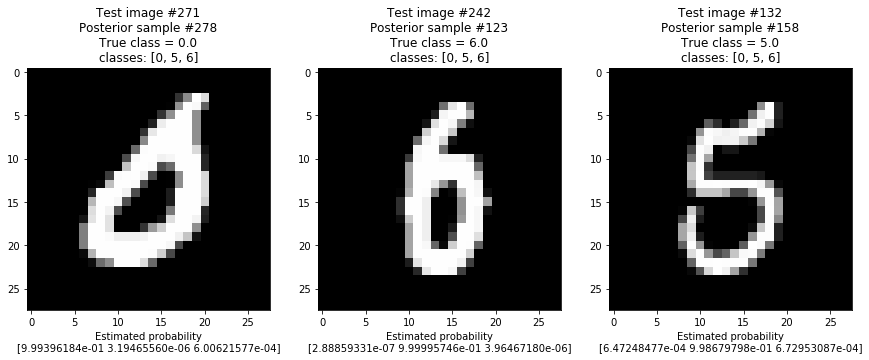

In [62]:
# The softmax function transforms each element of a collection by computing the exponential
# of each element divided by the sum of the exponentials of all the elements.

num_to_display = 4
fig = plt.figure(figsize=(20, 15))

# Select an image in the test set
for i in range(1, num_to_display):
    test_img_indx = random.randint(0, num_of_posterior_samples)

    # Select a sample in the posterior
    posterier_sample = random.randint(0, num_of_posterior_samples)

    beta  = np.hstack([np.zeros((x_train_shape, 1)),  posterior['beta'][posterier_sample,:] ])
    alpha = np.hstack([[0], posterior['alpha'][posterier_sample,:] ])
    image = X_val[test_img_indx,:].reshape(image_dimension, image_dimension)
    
    fig.add_subplot(1, num_to_display, i)
    title = "Test image #" + str(test_img_indx) + \
        "\nPosterior sample #" + str(posterier_sample) + \
        "\nTrue class = " + str(y_val[test_img_indx]) + \
        "\nclasses: " + str(classes)
    
    plt.xlabel("Estimated probability\n" + 
               str(softmax((np.array([X_val[test_img_indx,:].dot(beta) + alpha])))[0,:]))
    
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")


plt.show()

Depending on the digits chosen, on some executions, both digits were correctly classified but on some they were not. The output from 'classes' and the estimated probability should match the value in the 'True class' for a correctly identified number.

#### Calculate the digits with the highest posterior probability
The times are being measured for my own references only.

In [36]:
print("Start time {}".format(datetime.datetime.now().time()))
calc_y_pred_bayesian = calc_bay_pred(X_val, classes, x_train_shape, posterior)
print("Finish time {}".format(datetime.datetime.now().time()))

Start time 11:18:54.479032
Finish time 11:31:55.391400


In [37]:
print(calc_y_pred_bayesian)
print("Size of list {}".format(len(calc_y_pred_bayesian)))

[0, 2, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 0, 2, 1, 2, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 1, 2, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 

In [38]:
 # prediction array (using classes)
np.array(classes)[calc_y_pred_bayesian[0:100]]

array([0, 6, 6, 0, 5, 0, 6, 5, 5, 0, 6, 5, 0, 6, 5, 6, 0, 6, 6, 5, 6, 5,
       5, 0, 0, 0, 6, 5, 5, 0, 5, 6, 5, 0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6,
       0, 6, 5, 6, 6, 6, 6, 6, 5, 5, 5, 0, 0, 0, 6, 5, 6, 6, 5, 5, 5, 6,
       5, 5, 5, 0, 6, 0, 5, 0, 6, 6, 5, 6, 5, 6, 6, 0, 0, 5, 6, 6, 6, 6,
       5, 0, 0, 0, 0, 5, 6, 0, 6, 6, 0, 5])

In [39]:
print("10k accuracy =", accuracy_score(np.array(classes)[calc_y_pred_bayesian], y_val))

10k accuracy = 0.9703333333333334


In [40]:
# recall the classes we are using
print(classes)

[0, 5, 6]


The code below is printing the number of each of the digits(classes) selected. I notice that the first class chosen, always seems to have a slightly higher count than the others (~10%).

In [41]:
print(Counter(calc_y_pred_bayesian))

Counter({1: 1028, 2: 1011, 0: 961})


Test to see if the estimate of 4k will result in a similar accuracy to the above '10k' value.

In [42]:
fourk_posterior = approx4k.sample(draws=num_of_posterior_samples)

print("Start time {}".format(datetime.datetime.now().time()))
fourk_y_pred_bayesian = calc_bay_pred(X_val, classes, x_train_shape, fourk_posterior)
print("Finish time {}".format(datetime.datetime.now().time()))

print("Accuracy =", accuracy_score(np.array(classes)[fourk_y_pred_bayesian], y_val))

Start time 11:31:55.698842
Finish time 11:45:25.249471
Accuracy = 0.9703333333333334


No real difference in execution time but the accuracy is the same.

### Detect the instances (digits) in the test set that are hard to classify and remove them from the test-set <a id='diff_to_classify'></a>

In [43]:
print("Start time {}".format(datetime.datetime.now().time()))

y_predB=[]

for i in range(X_val.shape[0]):
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((x_train_shape,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    # mean probability
    valmean = np.mean(val,axis=0)
    
    # class with maximum mean probability
    classmax = np.argmax(valmean)
    
    # ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

print("Finish time {}".format(datetime.datetime.now().time()))

y_predB = np.array(y_predB)

Start time 11:45:25.261324
Finish time 11:59:28.046690


The next cell is showing a sample and what the probabilities for each digit are for that sample. It shows a definite decision for all of them.

In [44]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.92528729, 0.25514702],
       [2.        , 0.99999955, 0.        ],
       [2.        , 0.99999266, 0.        ],
       [0.        , 0.9741557 , 0.14      ],
       [1.        , 0.99629831, 0.04993746],
       [0.        , 0.99999992, 0.        ],
       [2.        , 0.98001144, 0.14      ],
       [1.        , 0.65505732, 0.46930134],
       [1.        , 0.99999437, 0.        ],
       [0.        , 1.        , 0.        ]])

#### Display data from difficult sets <a id='display_diff_res'></a>
Compare the above with below for a difficult set and you can see the probabilites are not so easy to be certain about.

In [45]:
# sorting in descending order

difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.50252264, 0.5       ],
       [1.        , 0.50093844, 0.5       ],
       [0.        , 0.50240753, 0.49999375],
       [2.        , 0.50496243, 0.49999375],
       [2.        , 0.50064301, 0.499975  ],
       [2.        , 0.47406371, 0.49994375],
       [2.        , 0.48207288, 0.49994375],
       [1.        , 0.51163682, 0.49994375],
       [1.        , 0.49872732, 0.49989999],
       [1.        , 0.48316648, 0.49989999]])

In [46]:
# Probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi != y_val]

array([0.93212152, 0.93162988, 0.999995  , ..., 0.99999999, 0.95418563,
       0.99232684])

In [47]:
y_predB[y_pred_logi != y_val,:]

array([[1.        , 0.81200947, 0.38418745],
       [0.        , 0.74670319, 0.4142463 ],
       [1.        , 0.81529135, 0.3923009 ],
       ...,
       [2.        , 0.82742328, 0.36890886],
       [2.        , 0.62803306, 0.47926376],
       [2.        , 0.92705352, 0.26339134]])

 Calculate the difficult & easy accuracy for comparison.

In [48]:

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]],
                                                     y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]],
                                                          y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.81


The above shows the difference between the accuracy of being able to clasify an easy vs difficult set and not suprisingly, there is a marked difference.

#### Display some images from both set types
Show a sample of 20 images from the easy list in colour and grayscale and grayscale for comparison.

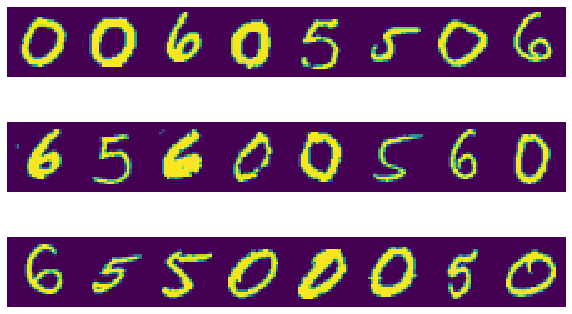

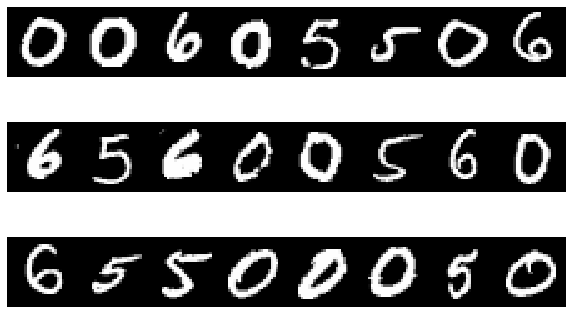

In [49]:
show_images(easy, X_val, 20)
show_images(easy, X_val, 20, image_dimension, True)

Show a sample of 20 images from the difficult list in colour and grayscale for comparison.

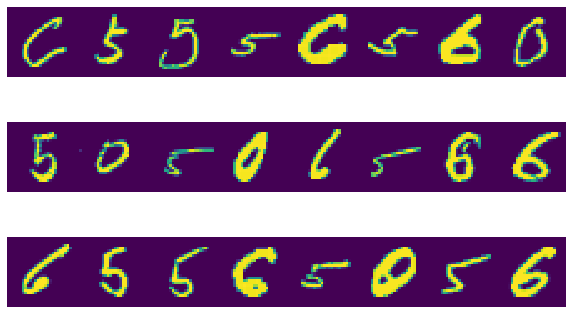

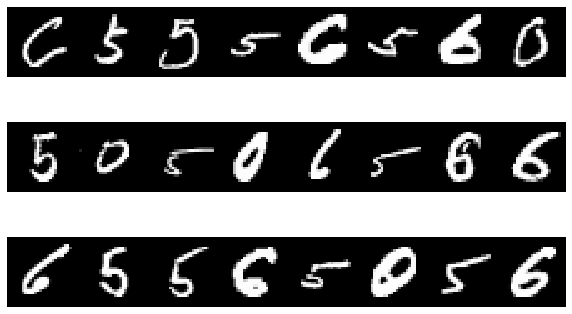

In [50]:

show_images(difficult, X_val, 20)
show_images(difficult, X_val, 20, image_dimension, True)

### Re-compute the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances  <a id='non_difficult_retest'></a>
Basic re-run of multinomial logistic regression without difficult samples without any attempt to determine what number of difficult digits to remove.

In [51]:

easy_model_log = LogisticRegression(random_state=0,
                               max_iter=2000,
                               C=100,
                               solver='lbfgs',
                               multi_class='multinomial').fit(X_train_shuf[easy],
                                                              y_train_shuf[easy])

# Classification:
y_pred_log_easy = easy_model_log.predict(X_val)
y_pred_logi_prob_easy = easy_model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax_easy = np.max(y_pred_logi_prob_easy, axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log_easy, y_val)

print("Original Model Accuracy {}".format(accuracy_score(y_pred_logi, y_val)))
print("Number of misclassifications {}".format(len(prob_classmax[y_pred_logi!=y_val])))

# Retrained
print("Retrained Model Accuracy: {}".format(accuracy_score(y_pred_log_easy, y_val)))
print("Number of misclassifications {}".format(len(prob_classmax_easy[y_pred_log_easy!=y_val])))

Original Model Accuracy 0.9636666666666667
Number of misclassifications 109
Retrained Model Accuracy: 0.9683333333333334
Number of misclassifications 95


There is a slight increase in the accuracy and decrease in the number of misclassifications for the easy set. This is expected since the number of difficult digits has been reduced.
* For 5000 samples for each class with 100 from the posterior sample:
    * The accuracy went from 0.9803333333333333 to 0.9816666666666667 and the misclassifications dropped from 59 to 55
* For 2500 samples for each class with 500 from the posterior sample:
    * The accuracy went from 0.986 to 0.9826666666666667 and the misclassifications increased from 21 to 26

#### Attempt to get some indication of what number of difficult digits to remove <a id='difficult_to_remove'></a>
This is from Robert Barrett in group 1.

Start time 11:59:34.675975


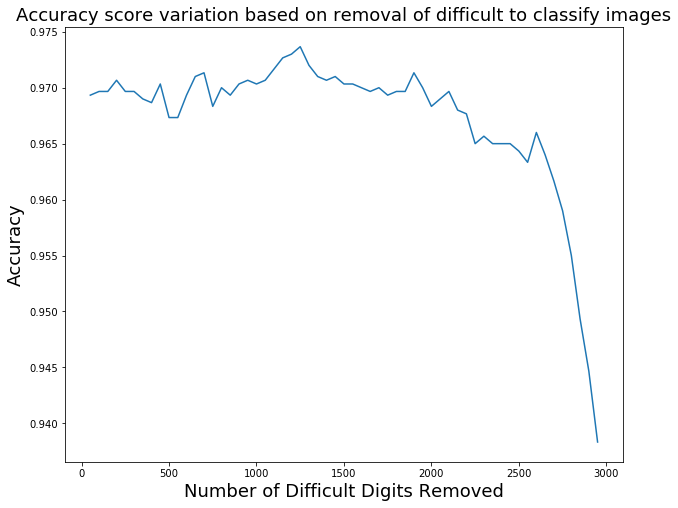

Finish time 12:01:13.440826


In [52]:
print("Start time {}".format(datetime.datetime.now().time()))

varying_results = []

# Cycle through a list in steps of 50
for i in list(np.arange(50, 3000, 50)):

  var_model_log = LogisticRegression(random_state=0,
                                 max_iter=2000,
                                 C=100,
                                 solver='lbfgs',
                                 multi_class='multinomial').fit(X_train_shuf[easy[0:i]],
                                                                y_train_shuf[easy[0:i]])

  # Classification:
  var_y_pred_log = var_model_log.predict(X_val)
  var_y_pred_logi_prob = var_model_log.predict_proba(X_val)

  # Maybe taking the maximum probability 
  # in any of the classes for each observation
  prob_classmax = np.max(var_y_pred_logi_prob,axis=1)

  # Computing the Accuracy:
  accuracy_score(var_y_pred_log, y_val)
  varying_results.append (accuracy_score(var_y_pred_log, y_val))


## Graphing the varying effects on accuracy of removing varying amounts of difficult to classify samples
varying_results.reverse()

plt.figure(figsize=(10,8))
plt.plot((list(np.arange(50, 3000, 50))), varying_results)

plt.title('Accuracy score variation based on removal of difficult to classify images',fontsize=18)
plt.xlabel('Number of Difficult Digits Removed',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.show()

print("Finish time {}".format(datetime.datetime.now().time()))

Start time 12:01:13.451153


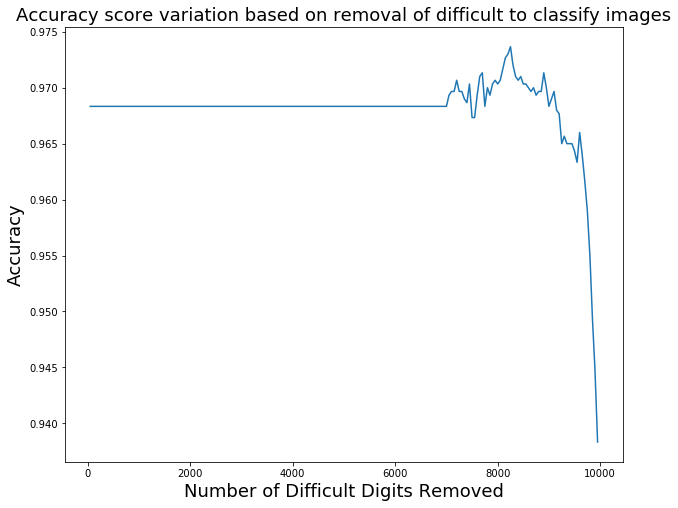

Finish time 12:12:23.454424


In [53]:
print("Start time {}".format(datetime.datetime.now().time()))

varying_results = []

# Cycle through a list in steps of 50
for i in list(np.arange(50, 10000, 50)):

  var_model_log = LogisticRegression(random_state=0,
                                 max_iter=2000,
                                 C=100,
                                 solver='lbfgs',
                                 multi_class='multinomial').fit(X_train_shuf[easy[0:i]],
                                                                y_train_shuf[easy[0:i]])

  # Classification:
  var_y_pred_log = var_model_log.predict(X_val)
  var_y_pred_logi_prob = var_model_log.predict_proba(X_val)

  # Maybe taking the maximum probability 
  # in any of the classes for each observation
  prob_classmax = np.max(var_y_pred_logi_prob,axis=1)

  # Computing the Accuracy:
  accuracy_score(var_y_pred_log, y_val)
  varying_results.append (accuracy_score(var_y_pred_log, y_val))


## Graphing the varying effects on accuracy of removing varying amounts of difficult to classify samples
varying_results.reverse()

plt.figure(figsize=(10,8))
plt.plot((list(np.arange(50, 10000, 50))), varying_results)

plt.title('Accuracy score variation based on removal of difficult to classify images',fontsize=18)
plt.xlabel('Number of Difficult Digits Removed',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.show()

print("Finish time {}".format(datetime.datetime.now().time()))

On some tests, the 2 sections above show, the accuracy does not drasticly drop until the last few hundred digits for 3000 and 10,000. We can remove those few hundred images - as an average across a number of test cycles, I am estimating 750 between both graphs - and test the accuracy again below.

In [54]:
easy_model_log2 = LogisticRegression(random_state=0,
                               max_iter=2000,
                               C=100,
                               solver='lbfgs',
                               multi_class='multinomial').fit(X_train_shuf[0:2250],
                                                              y_train_shuf[0:2250])

# Classification:
y_pred_log_easy2 = easy_model_log2.predict(X_val)
y_pred_logi_prob_easy2 = easy_model_log2.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax_easy = np.max(y_pred_logi_prob_easy2, axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log_easy2, y_val)

# Retrained
print("Model accuracy with last few difficult images removed: {}".format(accuracy_score(
    y_pred_log_easy2, y_val)))

print("Number of misclassifications {}".format(len(prob_classmax_easy[y_pred_log_easy2!=y_val])))

Model accuracy with last few difficult images removed: 0.967
Number of misclassifications 99


Depending on the test I have sen both and slight increase and decrease on the accuracy when these images have been removed, which would suggest that depending on the digits being tested against, some had sets of digits which were more difficult to identify and for those, further analysis would be needed.

In [55]:
print("Etivity-1 completion time {}".format(datetime.datetime.now().time()))

Etivity-1 completion time 12:12:26.044073


## Summary

#### Basic understanding
As I understand it, the etivity ask is to use posterior probability (Bayes - which is an adjustment on prior probability) which is the probability of an outcome given we have new information, to be able classify multiple types of events (not just true/false, events being hand written digits in this case) for the MNIST dataset and it is multinomial because the dataset is a set of handwritten digits from 0 - 9 and not just a set of 2 digits.<br>

#### Peer discussion
I found the questions and answers in group forums on the use of the other performance statistics (confusion matrix, F1 score etc) and softmax function and the code around it to be very helpful in trying to understand its use. I added that information to my own submission as well as information from the group 1 discussion around how to determine what the difficult digits are and how to determine a good amount to remove.

#### General
In relation to using Google Colab, I found the constant dissconnection issues I was having frustrating and I also experienced it disconnecting during the middle of a model calculation with a large number of samples. For this reason I have reverted to using a local notebook only.

The dataset [dataset](#dataset) used was a collection of handwritten digits totally 60,000 with 10,000 selected as the testing set. I downloaded and printed some of these from the original source (see [data_description](#data_description)) to see what they were like. It was then [normalised](#normalised) to reduce it to a common scale between 0 and 1.

The [class_distro](#class_distro) shows a fairly even spread of the digits across the dataset, so this makes comparing different sets of 3 classes worthwhile. During various tests, I did see a good mix of misclassified digits - see '[display_diff_res](#display_diff_res) data from difficult sets' for some of these - so I think the overall set does contain a good range from easy to difficult digits to identify.

I used 3 different types of randomly selected digits from the set of 10 for each test and I also tested with different number of samples for each of those along with different sample size from the generated posterior probability set. Not surprisingly, the 2 variables that had the greatest impact in execution time were the number of samples used from the posterior list and the number of digit/class instances that were used. These are detailed in the [gen_vars](#gen_vars) section near the top. The details of the times are in the [gen_mlr_times](#gen_mlr_times) markdown cell above. Increasing the number of class instances had a much larger effect on the execution time and there was no major increase in the reported accuracy with the much larger class instance size.

Not setting the seed allowed me to see the accuracy etc with different sets of 3 digits and they all ranged from ~93% - ~98% depending on sample size used etc. Using the same sample sizes for different sets resulted in very similar results, so for me using 5000 samples for each digit and 1000 from the resulting posterior sample set was not worth the large increase in run time when compared to using 2500 & 500 respectively.

The data was initially tested with a general multinomial logistic regression algorithm (section [gen_multinomial_lr](#gen_multinomial_lr)) which would then be compared with Probabilistic MLR. I did try increasing 1 parameter of that algorithm but this proved to have no effect. I also measured the performance of the MLR algorithm, see [model_stats](#model_stats) and [confusion_matrix](#confusion_matrix) sections. The precision, recall and F1-score for all tests were in the high 90's so indicates that the performance and accuracy are generally good.

Softmax is referred to as an activation function (defines an output given a set of inputs) and is used in this instance as the results are generally greater than zero as it uses the exponential. That is (> 0) required as you can't use zero or negative values to get probabilities. The use of the exponential helps to increase the probability of the largest score and decrease the probability of the smallest score. Some randomly selected test images were then displayed in the [softmax_image](#softmax_image) section. On some tests, incorrectly classified images were seen, most being from 2 - 9 range of digits.

The data was then tested with a probabilistic_multinomial_regression algorithm in section [probabilistic_ml_regression](#probabilistic_ml_regression). The purpose behind this was to add some prior knowledge of the classifications to the see what effect this would have. On some occasions, depending on the set of digits chosen, I did see a small improvement in the reported accuracy.

The hard to classify digits were then removed (see section [diff_to_classify](#diff_to_classify)) and the accuracy measured again in section [non_difficult_retest](#non_difficult_retest). The accuracy was then compared with the first test. There was as expected a noticible improvement in the accuracy when the difficult images were removed.

Despite varying the 3 classes chosen and the number of samples used, I did not see a major change in the accuracy of the model when only comparing the easier to classify datasets on each test. This could be down to the way I chose to find the difficult sets to identify and I note there is some discussion in the other groups on this also. I have used some of their methods in my notebook to measure changes in accuracy and when a selection of what was deemed to be difficult to identify images were removed in section [difficult_to_remove](#difficult_to_remove), the accuracy did improve but only by a small amount.

In conclusion, the application of MLR and the addition of posterior probability to this dataset did show that these performed well on the digits dataset and the ability of the PMLR to identify difficult sets could allow one to infer greater confidence in its results.

I think areas that are worth further exploration are:
* A more complete comparison of different sets of samples from the complete set of digits available along with larger datasets being applied to both the general MLR and the posterior probability algorithms. Producing a table of results for comparision would give grreater insight and confidence into the accuracy of these methods across a larger dataset.
* Is the correct measure of what a difficult digit could be and how to feed that data into the model used for better overall accuracy.

## References
These references are a combination of my own search and from posts by others.

### Websites
#### https://en.wikipedia.org/wiki/Maximum_likelihood_estimation
#### https://en.wikipedia.org/wiki/Posterior_probability
#### https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1
#### https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f
#### https://towardsdatascience.com/introduction-to-bayesian-logistic-regression-7e39a0bae691
#### https://pandas.pydata.org/docs/reference/api/pandas.read_pickle.html
#### https://docs.pymc.io/
#### https://machinelearningmastery.com/softmax-activation-function-with-python/
#### https://machinelearningmastery.com/confusion-matrix-machine-learning/
#### https://datascience.stackexchange.com/questions/23159/in-softmax-classifier-why-use-exp-function-to-do-normalization
#### https://statquest.org/
#### http://docs.zeligproject.org/articles/zelig_mlogitbayes.html
#### https://www.statisticshowto.com/
#### https://www.mathsisfun.com/sets/symbols.html


### Books/Papers
#### Salvatier J., Wiecki T.V., Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 DOI: 10.7717/peerj-cs.55.
#### David W.H. Swenson, "Statistics" http://www.cchem.berkeley.edu/chem120a/extra/statistics.pdf
#### Automatic Differentiation Variational Inference https://arxiv.org/pdf/1603.00788.pdf

In [56]:
#%%capture
#!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
#from colab_pdf import colab_pdf
#colab_pdf('Etivity_1_JohnHayes_9309888.ipynb')

The pdf output from above is not as good as a straight print to pdf using 
    `jupyter nbconvert --to webpdf --allow-chromium-download ET5003_Etivity1_JohnHayes_9309888.ipynb`